In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

In [2]:
txn = pd.read_csv("/Users/judepereira/Downloads/ieee-fraud-detection/train_transaction.csv")
idm = pd.read_csv("/Users/judepereira/Downloads/ieee-fraud-detection/train_identity.csv")

# derive “day” from TransactionDT, then drop the raw column
txn["day"] = (txn["TransactionDT"] // (3600 * 24)).astype(int)
txn.drop("TransactionDT", axis=1, inplace=True)

# merge identity info into transaction table
df = txn.merge(idm, on="TransactionID", how="left")
df.drop("TransactionID", axis=1, inplace=True)

In [3]:
# re-compute missing‐% for each V-column
vcols    = [c for c in df.columns if c.startswith("V")]
v_nulls  = df[vcols].isna().mean() * 100

# find your 40–60% and 60–80% bins
mask_40_60  = (v_nulls >= 40) & (v_nulls < 60)
mask_60_80  = (v_nulls >= 60) & (v_nulls < 80)

cols_40_60  = v_nulls[mask_40_60].index.tolist()
cols_60_80  = v_nulls[mask_60_80].index.tolist()
cols_80_100 = v_nulls[v_nulls >= 80].index.tolist()

# aggregate signals
df["V_40_60_missing_count"]  = df[cols_40_60].isna().sum(axis=1)
df["V_60_80_present_count"]  = df[cols_60_80].notna().sum(axis=1)

# drop the mostly‐always missing V's (>80% missing)
df.drop(columns=cols_80_100, inplace=True)

In [4]:
id_cols = [c for c in idm.columns if c.startswith("id_")]

# keep only low‐cardinality IDs (<=50 unique), drop the rest
keep_ids = [c for c in id_cols if df[c].nunique(dropna=False) <= 50]
drop_ids = [c for c in id_cols if c not in keep_ids]
df.drop(columns=drop_ids, inplace=True)

# fill & label‐encode the kept ID features
for c in keep_ids:
    df[c] = df[c].fillna("MISSING")
    df[c] = LabelEncoder().fit_transform(df[c].astype(str))

In [5]:
# numeric imputation (median) – exclude the target “isFraud”
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove("isFraud")

imputer = SimpleImputer(strategy="median")
df[num_cols] = imputer.fit_transform(df[num_cols])

# for remaining categoricals, one‐hot encode small‐cardinaliy ones
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
# e.g. “ProductCD”, “MISSING” placeholders, etc.
for c in cat_cols:
    n_uniq = df[c].nunique()
    if n_uniq <= 10:
        dummies = pd.get_dummies(df[c], prefix=c, drop_first=True)
        df = pd.concat([df.drop(c, axis=1), dummies], axis=1)
    else:
        # high‐cardinality strings you can label‐encode or drop
        df[c] = LabelEncoder().fit_transform(df[c].astype(str))

In [6]:
print("Final shape:", df.shape)
print("Example columns:", df.columns[:20])

Final shape: (590540, 378)
Example columns: Index(['isFraud', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8'],
      dtype='object')


In [7]:
# density model & scoring
from scipy.stats import multivariate_normal

# splitting & evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, precision_recall_fscore_support, roc_auc_score
)

In [8]:
# all non‐fraud examples
df_norm = df[df.isFraud == 0].copy()
# all fraud examples
df_fraud = df[df.isFraud == 1].copy()

# hold out 20% of normals for CV
norm_train, norm_cv = train_test_split(
    df_norm, test_size=0.2, random_state=42
)

# CV set = held‐out normals + all frauds
df_cv = pd.concat([norm_cv, df_fraud], axis=0)
y_cv  = df_cv["isFraud"].values

# drop labels for modeling
X_train = norm_train.drop("isFraud", axis=1).values
X_cv    = df_cv.drop("isFraud", axis=1).values

print("→ Training on normals only:", X_train.shape)
print("→ CV set (normals+fraud):", X_cv.shape)

→ Training on normals only: (455901, 377)
→ CV set (normals+fraud): (134639, 377)


In [9]:
# fit a multivariate Gaussian to the normals
from sklearn.covariance import EmpiricalCovariance
from scipy.stats import multivariate_normal

# fit covariance on your normal-only training set
ec = EmpiricalCovariance().fit(X_train)

mu  = ec.location_       # shape (377,)
cov = ec.covariance_     # shape (377, 377)

rv = multivariate_normal(mean=mu, cov=cov, allow_singular=True)

# log‐pdf on train vs CV
train_ll = rv.logpdf(X_train)
cv_ll    = rv.logpdf(X_cv)

In [10]:
# pick ε as the α‐percentile of train log‐likelihoods
# e.g. α = 5 means flag ~5% of normals as anomalies in‐sample
α = 30  
epsilon = np.percentile(train_ll, α)

print(f"Chosen ε = {epsilon:.2f} (the {α}th percentile of train log‐likelihood)")

Chosen ε = -563.11 (the 30th percentile of train log‐likelihood)


In [11]:
# anomaly if log‐likelihood < ε
y_pred = (cv_ll < epsilon).astype(int)

In [12]:
cm = confusion_matrix(y_cv, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
precision, recall, f1, _ = precision_recall_fscore_support(
    y_cv, y_pred, pos_label=1, average='binary'
)
#auc = roc_auc_score(y_cv, -cv_ll)  # higher “anomaly score” = more likely fraud

print("Confusion Matrix (CV):")
print(f"             Pred 0    Pred 1")
print(f"Actual 0       {tn:5d}      {fp:5d}")
print(f"Actual 1       {fn:5d}      {tp:5d}\n")

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")
#print(f"AUC (using –log‐likelihood): {auc:.3f}")

Confusion Matrix (CV):
             Pred 0    Pred 1
Actual 0       79442      34534
Actual 1        6352      14311

Precision: 0.293
Recall:    0.693
F1-score:  0.412


In [13]:
# compute raw anomaly scores
scores = -cv_ll

# find any +inf (which come from cv_ll == -inf)
inf_mask = np.isinf(scores)
if inf_mask.any():
    # choose a value just above the max finite score
    max_finite = scores[~inf_mask].max()
    scores[inf_mask] = max_finite + 1e-6

# now compute AUC
auc = roc_auc_score(y_cv, scores)
print(f"AUC (using –log‐likelihood, clipped): {auc:.3f}")

AUC (using –log‐likelihood, clipped): 0.760


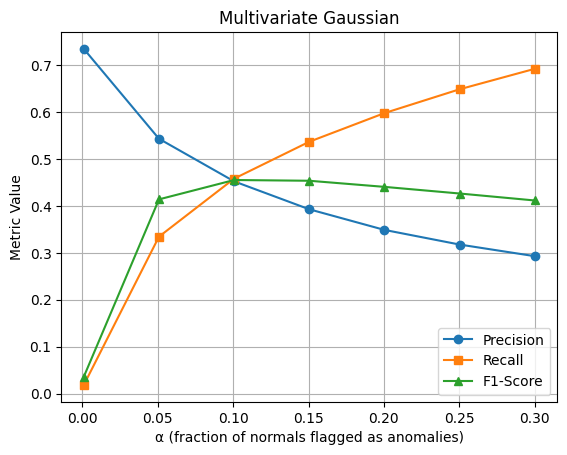

In [23]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

# Sweep alphas (fraction of normals flagged)
alphas = np.linspace(0.001, 0.3, 7)  # from 1% to 10%
precisions, recalls, f1s = [], [], []

for alpha in alphas:
    # set threshold at the alpha-percentile
    epsilon = np.percentile(train_ll, alpha * 100)
    y_pred = (cv_ll < epsilon).astype(int)

    p, r, f1, _ = precision_recall_fscore_support(
        y_cv, y_pred, pos_label=1, average='binary'
    )
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)

# Plot all three metrics against alpha
plt.figure()
plt.plot(alphas, precisions, marker='o', label='Precision')
plt.plot(alphas, recalls,    marker='s', label='Recall')
plt.plot(alphas, f1s,        marker='^', label='F1-Score')
plt.xlabel('α (fraction of normals flagged as anomalies)')
plt.ylabel('Metric Value')
plt.title('Multivariate Gaussian')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
from sklearn.mixture import GaussianMixture
#gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=42)

gmm = GaussianMixture(
    n_components=3,
    covariance_type="full",   # or "tied", "spherical"
    reg_covar=1e-5,           # adds 0.001 to diagonal of each covariance
    #init_params="kmeans",
    random_state=42,
    #max_iter=200
)
gmm.fit(X_train)
train_ll = gmm.score_samples(X_train)
cv_ll    = gmm.score_samples(X_cv)

In [25]:
# pick ε as the α‐percentile of train log‐likelihoods
# e.g. α = 5 means flag ~5% of normals as anomalies in‐sample
α = 30  
epsilon = np.percentile(train_ll, α)

print(f"Chosen ε = {epsilon:.2f} (the {α}th percentile of train log‐likelihood)")

Chosen ε = 531.61 (the 30th percentile of train log‐likelihood)


In [26]:
# anomaly if log‐likelihood < ε
y_pred = (cv_ll < epsilon).astype(int)

In [27]:
cm = confusion_matrix(y_cv, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
precision, recall, f1, _ = precision_recall_fscore_support(
    y_cv, y_pred, pos_label=1, average='binary'
)
#auc = roc_auc_score(y_cv, -cv_ll)  # higher “anomaly score” = more likely fraud

print("Confusion Matrix (CV):")
print(f"             Pred 0    Pred 1")
print(f"Actual 0       {tn:5d}      {fp:5d}")
print(f"Actual 1       {fn:5d}      {tp:5d}\n")

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")
#print(f"AUC (using –log‐likelihood): {auc:.3f}")

Confusion Matrix (CV):
             Pred 0    Pred 1
Actual 0       79426      34550
Actual 1        5718      14945

Precision: 0.302
Recall:    0.723
F1-score:  0.426


In [28]:
# compute raw anomaly scores
scores = -cv_ll

# find any +inf (which come from cv_ll == -inf)
inf_mask = np.isinf(scores)
if inf_mask.any():
    # choose a value just above the max finite score
    max_finite = scores[~inf_mask].max()
    scores[inf_mask] = max_finite + 1e-6

# now compute AUC
auc = roc_auc_score(y_cv, scores)
print(f"AUC (using –log‐likelihood, clipped): {auc:.3f}")

AUC (using –log‐likelihood, clipped): 0.782


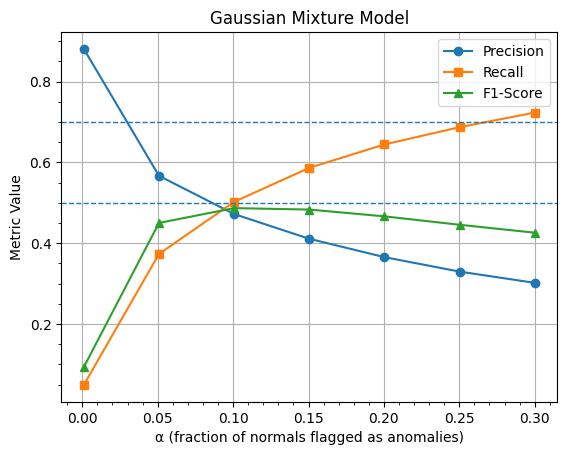

In [42]:
# Sweep alphas (fraction of normals flagged)
alphas = np.linspace(0.001, 0.3, 7)  # from 1% to 10%
precisions, recalls, f1s = [], [], []

for alpha in alphas:
    # set threshold at the alpha-percentile
    epsilon = np.percentile(train_ll, alpha * 100)
    y_pred = (cv_ll < epsilon).astype(int)

    p, r, f1, _ = precision_recall_fscore_support(
        y_cv, y_pred, pos_label=1, average='binary'
    )
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)

# Plot all three metrics against alpha
plt.figure()
plt.plot(alphas, precisions, marker='o', label='Precision')
plt.plot(alphas, recalls,    marker='s', label='Recall')
plt.plot(alphas, f1s,        marker='^', label='F1-Score')
# Add horizontal line at y=0.7
plt.axhline(y=0.5, linestyle='--', linewidth=1)
plt.axhline(y=0.7, linestyle='--', linewidth=1)
plt.xlabel('α (fraction of normals flagged as anomalies)')
plt.ylabel('Metric Value')
plt.title('Gaussian Mixture Model')
plt.legend()
plt.minorticks_on()
plt.grid(True)
#plt.grid(which='minor', color='r', linestyle='-', alpha=0.2)
plt.show()